In [8]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

from skimage import feature
from scipy import stats, ndimage
from scipy.misc import factorial as fac

import photutils

from astropy import units as u
from astropy import stats
from astropy import visualization
from astropy import coordinates
from astropy.table import Table, vstack
from astropy.io import ascii, fits
from astropy.modeling import models, fitting, custom_model

%load_ext autoreload
%autoreload 2

/Users/tim/conda/envs/astroconda/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
ACT = 104
NODE = 3222
BRAD = 3228.5

In [3]:
NODE*ACT

335088

In [4]:
# for each node, the influence from each actuator
surf2act = np.fromfile("../mmtwfs/data/Surf2ActTEL_32.bin", dtype=np.float32).reshape(NODE, ACT)
nodecoor = ascii.read("../mmtwfs/data/bcv_node_coordinates.dat", names=["bcv_id", "bcv_x", "bcv_y", "bcv_z"])
actcoor = ascii.read("../mmtwfs/data/actuator_coordinates.dat", names=["act_i", "act_x", "act_y", "act_type"])
for ax in ["bcv_x", "bcv_y"]:
    nodecoor[ax] /= BRAD
nodecoor['bcv_rho'] = np.sqrt(nodecoor['bcv_x']**2 + nodecoor['bcv_y']**2)
nodecoor['bcv_phi'] = np.arctan2(nodecoor['bcv_y'], nodecoor['bcv_x'])

In [5]:
actcoor['act_x'].unit = u.mm

In [6]:
actcoor

act_i,act_x,act_y,act_type
,mm,,
int64,float64,float64,int64
1,297.9,-3207.0,0
2,1085.0,-3033.0,0
3,1441.0,-2880.0,0
4,444.0,-2883.0,0
5,1054.0,-2787.0,0
6,1928.0,-2573.0,0
7,166.4,-2306.0,0
8,776.7,-2306.0,1


In [7]:
im = np.arange(90).reshape(9, 10)

In [8]:
np.indices(im.shape, dtype=float)

array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.],
        [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
        [ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.],
        [ 6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.],
        [ 7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.],
        [ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.]],

       [[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,

In [9]:
slopes = (np.indices(im.shape, dtype=float)/(np.r_[im.shape].reshape(-1, 1, 1))).reshape(2, -1)
slopes = np.vstack([slopes, np.ones(slopes.shape[1])])
slopes

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
         0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
         0.22222222,  0.22222222,  0.22222222,  0.22222222,  0.22222222,
         0.22222222,  0.22222222,  0.22222222,  0.22222222,  0.22222222,
         0.33333333,  0.33333333,  0.33333333,  0.33333333,  0.33333333,
         0.33333333,  0.33333333,  0.33333333,  0.33333333,  0.33333333,
         0.44444444,  0.44444444,  0.44444444,  0.44444444,  0.44444444,
         0.44444444,  0.44444444,  0.44444444,  0.44444444,  0.44444444,
         0.55555556,  0.55555556,  0.55555556,  0.55555556,  0.55555556,
         0.55555556,  0.55555556,  0.55555556,  0.55555556,  0.55555556,
         0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.66666667,
         0.66666667,  0.66666667,  0.66666667,  0.6

In [10]:
pinv = np.linalg.pinv(slopes)

In [11]:
np.dot(im.reshape(1, -1), pinv).ravel()[:2]

array([ 90.,  10.])

In [12]:
im

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89]])

In [13]:
import astropy.units as u

In [25]:
u.radian

Unit("rad")

In [15]:
a.to(u.nm).value

1000000.0

In [16]:
from mmtwfs.telescope import MMT

In [26]:
mmt = MMT()

In [27]:
mmt.diameter

<Quantity 6502.4 mm>

In [31]:
mmt.obscuration

<Quantity 0.2595964566929134>

In [35]:
12e6/(128*128)

732.421875

In [36]:
12e6/(4008*2672)

1.1205134640897845

In [1]:
import poppy

/Users/tim/conda/envs/astroconda/lib/python3.5/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/tim/conda/envs/astroconda/lib/python3.5/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [4]:
ap = poppy.HexagonAperture?

In [5]:
ap = poppy.HexagonAperture(side=1.0, rotation=30)

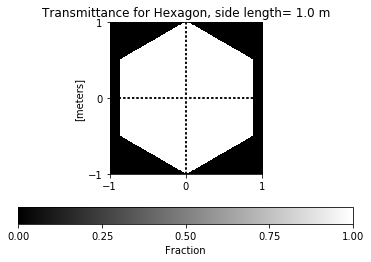

In [11]:
ap.display(colorbar=False)
plt.show()

In [17]:
arr = ap.to_fits(npix=27)[0].data.astype(float)

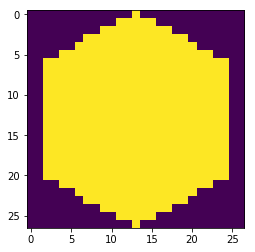

In [18]:
plt.imshow(arr)
plt.show()

In [21]:
from mmtwfs.telescope import MMT
from mmtwfs.zernike import ZernikeVector

In [20]:
t = MMT()

In [30]:
zv = ZernikeVector(Z05=-1000)

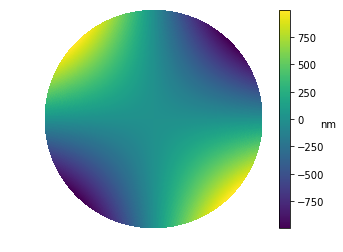

In [31]:
zv.plot_map()
plt.show()

In [27]:
print(zv)

Phase Amplitude Coefficients
 Z06:    -1e+03 nm 	 Primary Astig at 0˚ (2, 2)

